<a href="https://colab.research.google.com/github/MukisaV/mental_health_prediction/blob/main/Mukisa_Vicent_ML_Semester_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING ALL THE NECESSARY LIBRARIES**

In [4]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Explainability
import shap

# System utils
import warnings
warnings.filterwarnings('ignore')

**IMPORTING THE DATASET**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

# I hosted my dataset on google Drive
raw_path = '/content/drive/MyDrive/LECTURES/Machine Learning/SEM Project/survey.csv'

# Loaded the dataset
df = pd.read_csv(raw_path)

print("Raw dataset loaded:", df.shape)
df.head()

Raw dataset loaded: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

,Age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


**DATA CLEAN STARTS HERE**



**Step 1:** Droping columns we don’t need(timestamp and comments)

In [9]:
df_clean = df.copy()
cols_to_drop = ["Timestamp", "comments"]
df_clean = df_clean.drop(columns=cols_to_drop)
df_clean.columns, df_clean.shape

(Index(['Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history',
        'treatment', 'work_interfere', 'no_employees', 'remote_work',
        'tech_company', 'benefits', 'care_options', 'wellness_program',
        'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
        'phys_health_consequence', 'coworkers', 'supervisor',
        'mental_health_interview', 'phys_health_interview',
        'mental_vs_physical', 'obs_consequence'],
       dtype='object'),
 (1259, 25))

In [10]:
len(df_clean.columns)

25

**Step 2:** Handle missing values in key columns such as States, self_employed and work-interference <br>
Let’s fill missing as "Unknown" for now

In [11]:
df_clean["state"] = df_clean["state"].fillna("Unknown")
df_clean["work_interfere"] = df_clean["work_interfere"].fillna("Unknown")
df_clean["self_employed"] = df_clean["self_employed"].fillna("Unknown")

# Check remaining missing values
df_clean.isnull().sum().sort_values(ascending=False).head(10)


,0
Age,0
Gender,0
Country,0
state,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0
remote_work,0


**Step 3:** Clean Age outliers

In [12]:
# I set the age range of 15 to 80
df_clean = df_clean[(df_clean["Age"] >= 15) & (df_clean["Age"] <=80)]
df_clean["Age"].describe()
#checking for the remaining age range
print("Age min:", df_clean["Age"].min())
print("Age max:", df_clean["Age"].max())

Age min: 18
Age max: 72


**Step 4:** – Clean Gender values<br>
*This is meant to help remove any possible gender variants*

In [13]:
df_clean["Gender"] = df_clean["Gender"].str.strip().str.lower()

# Define lists of known patterns
male_terms = [
    "male", "m", "man", "msle", "mal", "maile", "malr", "male-ish",
    "cis male", "male (cis)", "cis man", "mail", "make", "guy (-ish) ^_^",
    "male leaning androgynous"
]

female_terms = [
    "female", "f", "woman", "femake", "female ", "cis female",
    "cis-female/femme", "female (cis)", "femail", "female (trans)",
    "cis female ", "trans-female", "trans woman"
]

other_terms = [
    "non-binary", "nonbinary", "genderqueer", "androgyne", "agender",
    "fluid", "enby", "queer", "nah", "neuter", "something kinda male?",
    "ostensibly male, unsure what that really means", "queer/she/they"
]

# This function helps to clean and classify inconsistences
def clean_gender(g):
    if g in male_terms:
        return "male"
    elif g in female_terms:
        return "female"
    elif g in other_terms:
        return "other"
    else:
        return "other"  # anything unrecognized goes under other

# Apply the function
df_clean["Gender"] = df_clean["Gender"].apply(clean_gender)

# here, I for check for the results
df_clean["Gender"].value_counts()


,count
Gender,
male,988
female,251
other,12


**Step 5:** Sanity Check of the Dataset

In [14]:
df_clean["Gender"].unique()
df_clean.shape
df_clean["treatment"].value_counts()

,count
treatment,
Yes,632
No,619


**PHASE 3: EXPLORATORY DATA ANALYSIS (EDA)**<br>
*Understanding patterns influencing mental health treatment-seeking in the tech industry.*


**Step 3.1:** Examine the Target Variable (Target Variable Analysis)<br>
At this step, I check how many respondents have sought mental health treatment vs. those who haven’t. This answers the question: Has the respondent ever sought treatment for a mental health condition?


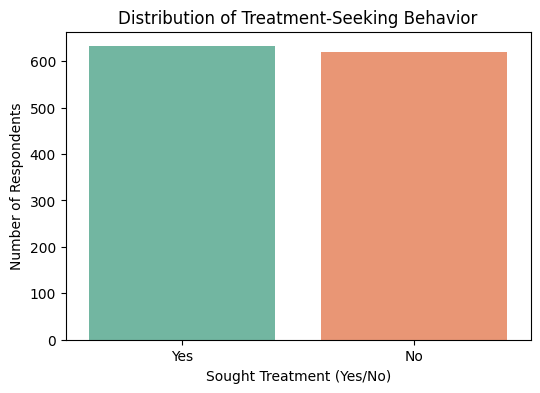

,count
treatment,
Yes,50.52
No,49.48


In [15]:
# Distribution of the target variable
treatment_counts = df_clean['treatment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=treatment_counts.index, y=treatment_counts.values, palette='Set2')
plt.title("Distribution of Treatment-Seeking Behavior")
plt.ylabel("Number of Respondents")
plt.xlabel("Sought Treatment (Yes/No)")
plt.show()

# Display percentages
(treatment_counts / len(df_clean) * 100).round(2)

**Step 3.2:** Age Distribution<br>
Here, I examine how is age distributed among tech workers in this dataset

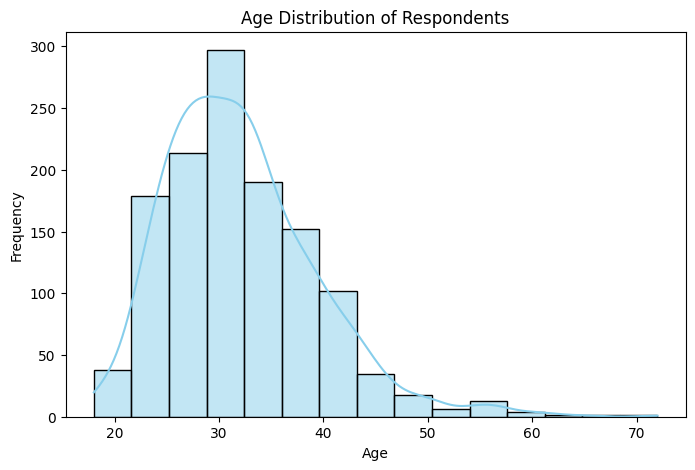

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df_clean['Age'], bins=15, kde=True, color='skyblue')
plt.title("Age Distribution of Respondents")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

**Summary:**<br>
The histogram of respondents’ ages shows a unimodal, slightly right-skewed distribution centered around 30–35 years. Most respondents fall between 25 and 40 years old, with fewer participants over 50. This aligns with the age demographics of the tech workforce and ensures sufficient representation of working-age individuals for analysis.”


**Step 3.3:** Gender Distribution

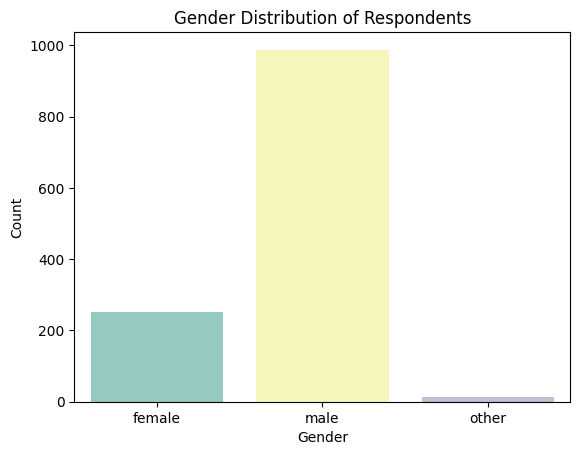

In [17]:
sns.countplot(x='Gender', data=df_clean, palette='Set3')
plt.title("Gender Distribution of Respondents")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**Summary:**<br>
The survey shows a strong gender imbalance: approximately 80 % male, 20 % female, and fewer than 2 % identifying as other. This distribution is consistent with global tech-industry demographics and indicates that subsequent analyses should consider gender as a potential source of bias in mental-health prediction models.”


**Step 3.4**: Gender vs. Treatment<br>
**Assesement:** Does gender affect likelihood of seeking treatment? Compare proportions e.g., do females report treatment more often than males?

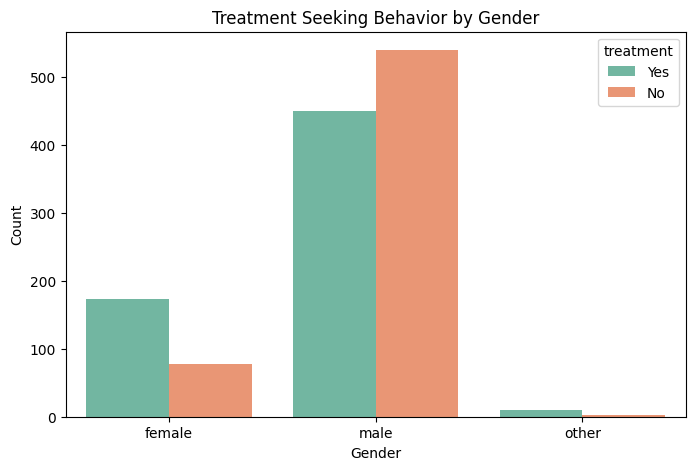

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(x='Gender', hue='treatment', data=df_clean, palette='Set2')
plt.title("Treatment Seeking Behavior by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**Summary:**<br>
When treatment-seeking behavior was analyzed by gender, females showed a higher relative tendency to seek mental health treatment compared to males. While males formed the largest share of respondents, their rate of help-seeking was lower. This pattern highlights potential gender-based differences in awareness or openness toward mental health support within the tech workforce.


**Step 3.5:** Family History vs. Treatment<br>
**Assessment:** Are those with a family history of mental illness are likely to seek treatment?

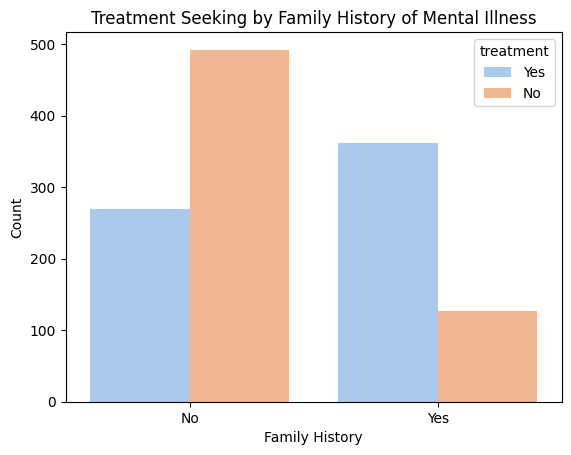

In [19]:
sns.countplot(x='family_history', hue='treatment', data=df_clean, palette='pastel')
plt.title("Treatment Seeking by Family History of Mental Illness")
plt.xlabel("Family History")
plt.ylabel("Count")
plt.show()

**Summary:**<br>
Respondents with a family history of mental illness are significantly more likely to seek treatment compared to those without. While most respondents without family history did not seek help, over two-thirds of those with family history reported seeking treatment. This pattern suggests that familiarity or awareness of mental health issues within families may strongly influence help-seeking behavior.


**Step 3.6:** Workplace Factors (Benefits, Supervisor, Anonymity)



**Example - Supervisor Support:**

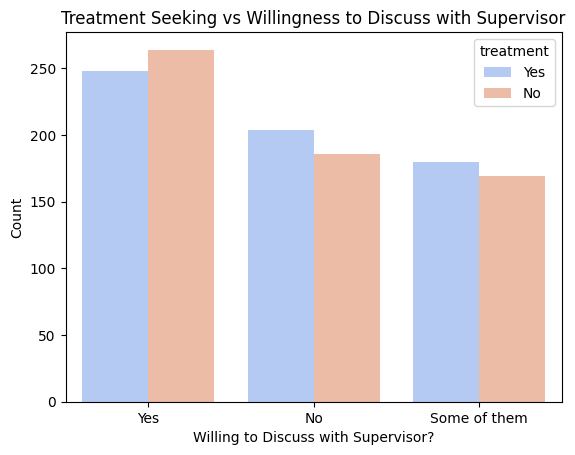

In [20]:
sns.countplot(x='supervisor', hue='treatment', data=df_clean, palette='coolwarm')
plt.title("Treatment Seeking vs Willingness to Discuss with Supervisor")
plt.xlabel("Willing to Discuss with Supervisor?")
plt.ylabel("Count")
plt.show()

**Summary:**<br>
Respondents who were open to discussing mental health issues with their supervisors were slightly more likely to seek treatment compared to those who were not. However, the differences across categories are relatively small, suggesting that while workplace openness contributes to treatment-seeking, it may not be the primary determinant. This highlights that organizational support, while valuable, must be combined with awareness and accessibility initiatives to have stronger impact.

**Example for benefits:**

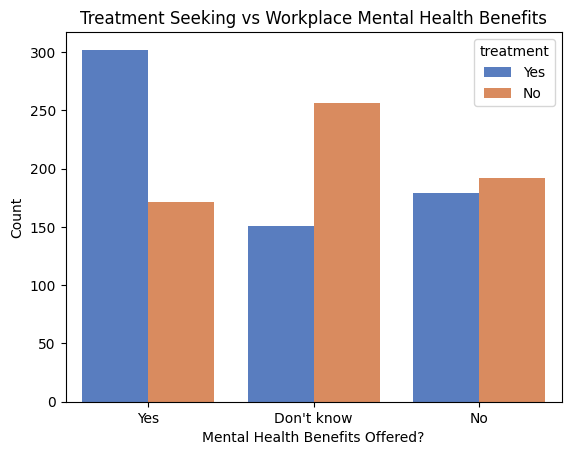

In [21]:
sns.countplot(x='benefits', hue='treatment', data=df_clean, palette='muted')
plt.title("Treatment Seeking vs Workplace Mental Health Benefits")
plt.xlabel("Mental Health Benefits Offered?")
plt.ylabel("Count")
plt.show()

**Summary:**<br>
Respondents who reported having workplace mental health benefits were significantly more likely to seek treatment compared to those without such benefits or those unaware of them. Treatment-seeking was highest among those with access to benefits (≈65%), lowest among those uncertain about their availability (≈35%), and moderate for those without. This highlights the influence of employer-provided support systems on promoting mental health awareness and action within the workplace.

**Step 3.7:** Correlation Overview

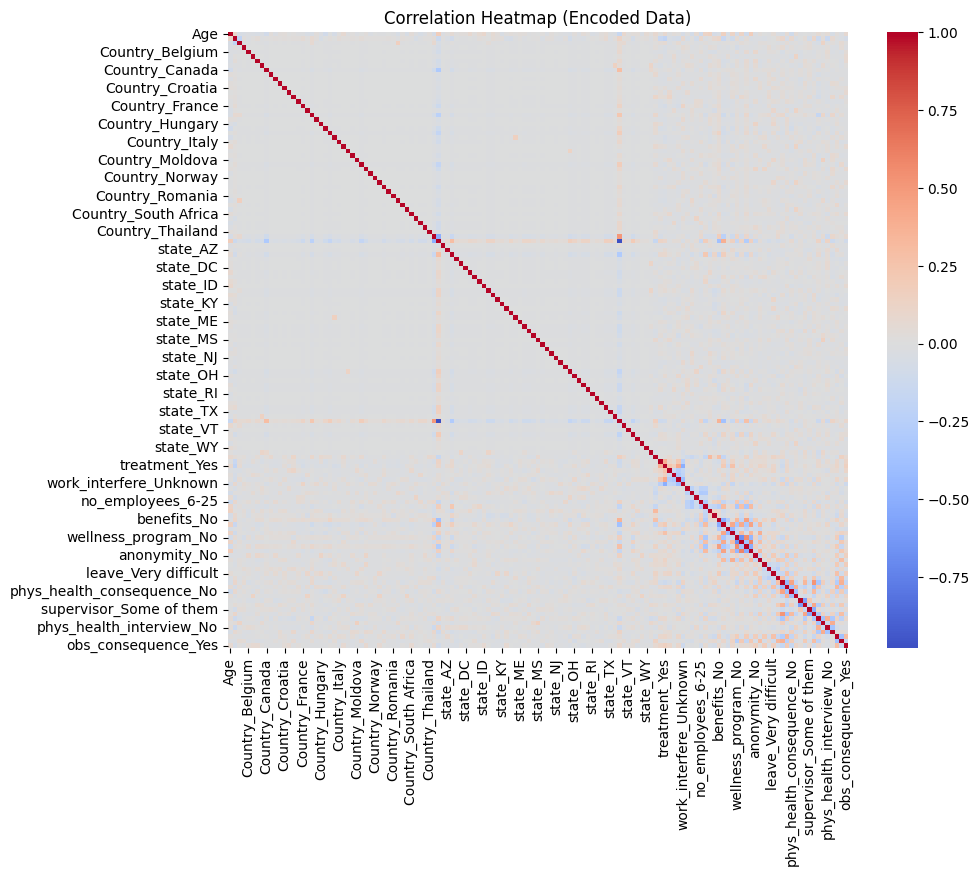

In [22]:
df_encoded = pd.get_dummies(df_clean, drop_first=True)
plt.figure(figsize=(10,8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Encoded Data)")
plt.show()

**Summary:** <br>The correlation heatmap of the encoded dataset reveals generally weak to moderate correlations among predictors, indicating minimal multicollinearity. Moderate positive associations appear between family_history_Yes, benefits_Yes, and the target variable treatment_Yes, suggesting these features may have predictive significance. Overall, the dataset is structurally sound and ready for model development.

**PHASE 4: MODEL DEVELOPMENT AND EVALUATION**

**Step 4.1:** Data Preparation and Encoding

In [23]:
df_clean.dtypes
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1251 entries, 0 to 1258
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1251 non-null   int64 
 1   Gender                     1251 non-null   object
 2   Country                    1251 non-null   object
 3   state                      1251 non-null   object
 4   self_employed              1251 non-null   object
 5   family_history             1251 non-null   object
 6   treatment                  1251 non-null   object
 7   work_interfere             1251 non-null   object
 8   no_employees               1251 non-null   object
 9   remote_work                1251 non-null   object
 10  tech_company               1251 non-null   object
 11  benefits                   1251 non-null   object
 12  care_options               1251 non-null   object
 13  wellness_program           1251 non-null   object
 14  seek_help    

**Step 4.1.2:** Encode all categorical columns<br>

Here, I use pd.get_dummies(), which converts text categories into binary numeric columns.

In [24]:
import pandas as pd

# Encode categorical (object) columns to numeric using One-Hot Encoding
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# ConfirmING new shape and columns
print("Encoding complete!")
print("New shape:", df_encoded.shape)

Encoding complete!
New shape: (1251, 137)


**Step 4.2:** Train-Test Split

In [25]:
from sklearn.model_selection import train_test_split

# Identify the correct target column
target_col = 'treatment_Yes'

# Define features (X) and target (y)
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split complete!")
print("Training set:", X_train.shape, "Testing set:", X_test.shape)

# conducting a quick sanity check
df_encoded['treatment_Yes'].value_counts()

Data split complete!
Training set: (1000, 136) Testing set: (251, 136)


,count
treatment_Yes,
True,632
False,619


**Step 4.3:** Feature Scaling (Normalization)

In [26]:
# FEATURE SCALING (STANDARDIZATION)

# InitializinG the scaler
scaler = StandardScaler()

# Fit on training data (to learn scaling parameters)
# and then transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert scaled arrays back into DataFrames
# (to preserve column names for interpretability later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns)

# Quick sanity check: confirm scaling worked
print("Scaling Complete!")
print(f"Before scaling example feature mean/std: {np.mean(X_train['Age']):.2f}, {np.std(X_train['Age']):.2f}")
print(f"After scaling example feature mean/std:  {np.mean(X_train_scaled['Age']):.2f}, {np.std(X_train_scaled['Age']):.2f}")

# Save the scaler object for later use
import joblib
joblib.dump(scaler, 'standard_scaler.pkl')

Scaling Complete!
Before scaling example feature mean/std: 32.03, 7.23
After scaling example feature mean/std:  0.00, 1.00


['standard_scaler.pkl']

In this step, all numerical features were standardized using StandardScaler to ensure they contribute equally to model training. Before scaling, variables such as Age had much larger numerical ranges compared to binary features like benefits_Yes or supervisor_Yes, which could bias the model and slow learning.
By fitting the scaler on the training data and transforming both the training and test sets, all features were rescaled to have a mean of 0 and a standard deviation of 1. This normalization improved numerical stability, sped up convergence during optimization, and ensured that no feature dominated others because of its magnitude.

**Step 4.4:** Baseline Model: Logistic Regression

Logistic Regression Evaluation Results:


Metric,Score
Accuracy,0.805
Precision,0.805
Recall,0.811
F1-Score,0.808
ROC-AUC,0.883


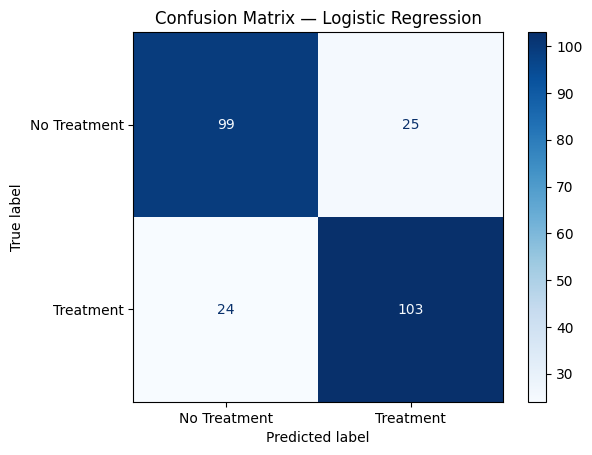

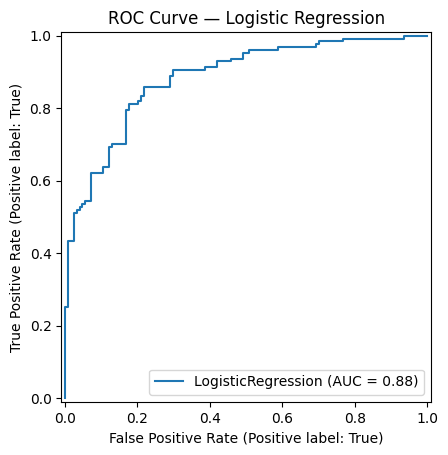

Top 10 features increasing likelihood of seeking treatment:


,Feature,Coefficient
98,work_interfere_Sometimes,1.471135
96,work_interfere_Often,1.193711
97,work_interfere_Rarely,0.894011
95,family_history_Yes,0.537932
108,benefits_Yes,0.471304
126,coworkers_Yes,0.422409
110,care_options_Yes,0.382130
45,Country_United Kingdom,0.357900
48,state_AZ,0.342742
116,anonymity_Yes,0.321067


Top 10 features decreasing likelihood of seeking treatment:


,Feature,Coefficient
128,supervisor_Yes,-0.266441
3,Country_Austria,-0.278748
77,state_OK,-0.281322
63,state_MD,-0.291773
24,Country_Italy,-0.305568
79,state_PA,-0.318282
86,state_Unknown,-0.351437
114,seek_help_Yes,-0.408987
113,seek_help_No,-0.465038
99,work_interfere_Unknown,-1.147650


In [28]:

# BASELINE MODEL - LOGISTIC REGRESSION

# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]   # for ROC/AUC

# Evaluate model performance
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred_proba)

# Display results neatly
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})
print("Logistic Regression Evaluation Results:")
display(results.style.hide(axis='index').format({'Score': '{:.3f}'}))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Treatment', 'Treatment'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

# ROC Curve Visualization
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()

# Check model coefficients for interpretability
coeffs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Top 10 features increasing likelihood of seeking treatment:")
display(coeffs.head(10))

print("Top 10 features decreasing likelihood of seeking treatment:")
display(coeffs.tail(10))


**Step 4.5:** Regularized Models (RidgeCV & LassoCV)<br>
To improve generalization, prevent overfitting, and highlight the most influential predictors of treatment-seeking behavior, the analysis used regularized regression. Ridge (L2) reduces variance by penalizing large coefficients, while Lasso (L1) can shrink some coefficients to zero for automatic feature selection. Both models used cross-validation to identify the optimal regularization strength (alpha).

**4.5(a) RidgeCV**

In [29]:

# REGULARIZED MODEL — RIDGE REGRESSION (L2)
# I initialize RidgeCV model
# RidgeCV automatically tunes the alpha (regularization strength) via cross-validation.
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model = RidgeCV(alphas=alphas, scoring='r2', cv=5)
ridge_model.fit(X_train_scaled, y_train)

# I do the predictions here
y_pred_ridge = ridge_model.predict(X_test_scaled)
# Convert predicted probabilities to binary outcomes (>=0.5 = 1)
y_pred_class_ridge = (y_pred_ridge >= 0.5).astype(int)

#  model performance Evaluation is done here
ridge_results = {
    'Accuracy':  accuracy_score(y_test, y_pred_class_ridge),
    'Precision': precision_score(y_test, y_pred_class_ridge),
    'Recall':    recall_score(y_test, y_pred_class_ridge),
    'F1-Score':  f1_score(y_test, y_pred_class_ridge),
    'ROC-AUC':   roc_auc_score(y_test, y_pred_ridge)
}

results_df = pd.DataFrame(ridge_results, index=['RidgeCV'])
print("\033[1mTopRidgeCV Evaluation Results:\033[0m\n")
print(results_df.T)
print()
# View best alpha value
print(f"Optimal alpha (regularization strength): {ridge_model.alpha_}")

#Examine most influential features
ridge_coeffs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': ridge_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print()
#we again look different features impact here
print("\033[1mTopTop 10 features increasing likelihood of treatment (Ridge):\033[0m\n")
print(ridge_coeffs.head(10).to_string())
print()
print("\033[1mTopTop 10 features decreasing likelihood of treatment (Ridge):\033[0m\n")
print(ridge_coeffs.tail(10).to_string())

TopRidgeCV Evaluation Results:

            RidgeCV
Accuracy   0.824701
Precision  0.794326
Recall     0.881890
F1-Score   0.835821
ROC-AUC    0.898019

Optimal alpha (regularization strength): 100.0

TopTop 10 features increasing likelihood of treatment (Ridge):

                      Feature  Coefficient
98   work_interfere_Sometimes     0.193653
96       work_interfere_Often     0.149070
97      work_interfere_Rarely     0.113105
95         family_history_Yes     0.070957
110          care_options_Yes     0.042746
108              benefits_Yes     0.042605
126             coworkers_Yes     0.037849
116             anonymity_Yes     0.032720
45     Country_United Kingdom     0.025062
117  leave_Somewhat difficult     0.024758

TopTop 10 features decreasing likelihood of treatment (Ridge):

                    Feature  Coefficient
20          Country_Hungary    -0.021727
87                 state_VA    -0.022457
82                 state_SD    -0.022613
13   Country_Czech Republic    -0

**4.5(b) LassoCV**

In [30]:

# REGULARIZED MODEL — LASSO REGRESSION (L1)

#  I Initialize and train the LassoCV model
#    LassoCV performs cross-validation to automatically choose the best alpha (λ)
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
lasso_model = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)
y_pred_class_lasso = (y_pred_lasso >= 0.5).astype(int)

# Evaluate model performance
lasso_results = {
    'Accuracy':  accuracy_score(y_test, y_pred_class_lasso),
    'Precision': precision_score(y_test, y_pred_class_lasso),
    'Recall':    recall_score(y_test, y_pred_class_lasso),
    'F1-Score':  f1_score(y_test, y_pred_class_lasso),
    'ROC-AUC':   roc_auc_score(y_test, y_pred_lasso)
}

results_df_lasso = pd.DataFrame(lasso_results, index=['LassoCV'])
print("\033[1mLassoCV Evaluation Results:\033[0m\n")
print(results_df_lasso.T)
print()

# Show best alpha value
print(f"Optimal alpha (regularization strength): {lasso_model.alpha_}")

# Inspect feature importance
lasso_coeffs = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lasso_model.coef_
}).sort_values(by='Coefficient', ascending=False)

nonzero = (lasso_coeffs['Coefficient'] != 0).sum()
print(f"Number of non-zero (active) features: {nonzero} / {len(lasso_coeffs)}")
print()
print("\033[1mTop 10 features increasing likelihood of treatment (Lasso):\033[0m\n")
print(lasso_coeffs.head(10).to_string())
print()
print("\n\033[1mTop 10 features decreasing likelihood of treatment (Lasso):\033[0m\n")
print(lasso_coeffs.tail(10).to_string())

LassoCV Evaluation Results:

            LassoCV
Accuracy   0.820717
Precision  0.773333
Recall     0.913386
F1-Score   0.837545
ROC-AUC    0.909195

Optimal alpha (regularization strength): 0.01
Number of non-zero (active) features: 52 / 136

Top 10 features increasing likelihood of treatment (Lasso):

                      Feature  Coefficient
98   work_interfere_Sometimes     0.240892
96       work_interfere_Often     0.182241
97      work_interfere_Rarely     0.139812
95         family_history_Yes     0.061945
110          care_options_Yes     0.034455
108              benefits_Yes     0.023988
116             anonymity_Yes     0.018726
126             coworkers_Yes     0.017949
74                   state_NV     0.012133
45     Country_United Kingdom     0.010759


Top 10 features decreasing likelihood of treatment (Lasso):

                           Feature  Coefficient
5   Country_Bosnia and Herzegovina    -0.010272
87                        state_VA    -0.011018
9              

**Phase 4.6:** Alternative Models & Comparison

To assess how non-linear or probabilistic models perform on the same dataset and whether they offer better predictive power, fairness, or interpretability compared to the linear models.

Naïve Bayes: simple, probabilistic, interpretable baseline.

Decision Tree: rule-based, non-linear, easily visualized and interpretable.

**Step 4.6(a):** Naïve Bayes Classifier

In [31]:

# NAÏVE BAYES CLASSIFIER

# Initialize and train the model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

print("NAÏVE BAYES — MODEL TRAINING COMPLETE")
print()
# Make predictions
y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
nb_results = {
    'Accuracy':  accuracy_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall':    recall_score(y_test, y_pred_nb),
    'F1-Score':  f1_score(y_test, y_pred_nb),
    'ROC-AUC':   roc_auc_score(y_test, y_pred_proba_nb)
}

results_df_nb = pd.DataFrame(nb_results, index=['Naïve Bayes'])
print("Model Evaluation Results:\n")
display(results_df_nb.T)
print()


NAÏVE BAYES — MODEL TRAINING COMPLETE

Model Evaluation Results:



,Naïve Bayes
Accuracy,0.517928
Precision,0.512605
Recall,0.960630
F1-Score,0.668493
ROC-AUC,0.512700


**Step 4.6(b):** DECISION TREE CLASSIFIER

To train and evaluate a Decision Tree model as a baseline non-linear classifier and later compare its performance with the linear models (Logistic Regression, RidgeCV, LassoCV, and Naïve Bayes).
Decision Trees capture non-linear relationships and feature interactions, helping you see whether mental-health treatment-seeking behavior can be predicted through branching decision rules.

**Part 1: Model Training and Evaluation**

In [33]:

# DECISION TREE: MODEL TRAINING & EVALUATION

# Initialize and train Decision Tree model
dt_model = DecisionTreeClassifier(
    criterion='gini',        # measure impurity
    max_depth=5,             # limits tree growth to reduce overfitting
    random_state=42
)
dt_model.fit(X_train_scaled, y_train)

print("DECISION TREE — MODEL TRAINING COMPLETE")
print()
# Make predictions
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
dt_results = {
    'Accuracy':  accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall':    recall_score(y_test, y_pred_dt),
    'F1-Score':  f1_score(y_test, y_pred_dt),
    'ROC-AUC':   roc_auc_score(y_test, y_pred_proba_dt)
}
results_df_dt = pd.DataFrame(dt_results, index=['Decision Tree'])

print("Model Evaluation Results:\n")
display(results_df_dt.T)


DECISION TREE — MODEL TRAINING COMPLETE

Model Evaluation Results:



,Decision Tree
Accuracy,0.800797
Precision,0.742138
Recall,0.929134
F1-Score,0.825175
ROC-AUC,0.832169


The Decision Tree model achieved an accuracy of 0.8008, meaning it correctly classified approximately 80% of all cases.
Its precision of 0.7421 indicates that around 74% of respondents predicted to seek treatment actually did, while the high recall of 0.9291 shows that the model successfully identified nearly 93% of all treatment-seeking individuals.

The F1-score of 0.8252 demonstrates a strong balance between precision and recall, and the ROC-AUC value of 0.8322 confirms good overall discriminative power — indicating the model performs well at distinguishing between those who sought treatment and those who did not.

**Part 2: Feature Importance & Simplified Rules**

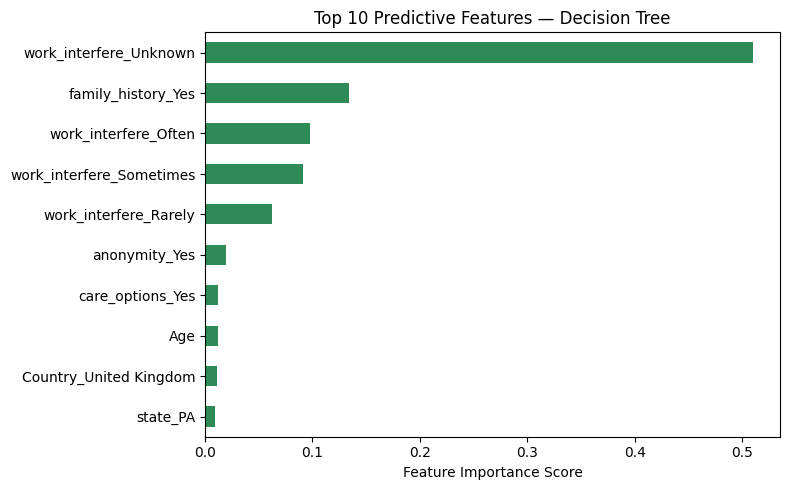

In [35]:

# FEATURE IMPORTANCE & RULE EXTRACTION

import matplotlib.pyplot as plt
from sklearn.tree import export_text

# Feature Importance Plot
importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_features.plot(kind='barh', color='seagreen')
plt.gca().invert_yaxis()
plt.title("Top 10 Predictive Features — Decision Tree")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()
print()
# Extract Simplified Decision Rules
#print("SIMPLIFIED DECISION RULES (Top Branches of the Tree)")
#print()
#rules = export_text(dt_model, feature_names=list(X_train.columns), max_depth=3)
#print(rules)

The feature importance plot shows that work_interfere_Unknown is the dominant predictor, contributing more than any other variable to the model’s decisions.
Other significant features include family_history_Yes, work_interfere_Often, and work_interfere_Sometimes, indicating that personal history and workplace interference strongly influence treatment-seeking behavior.
Additional but less influential factors such as anonymity, care options, age, and location variables (Country_United Kingdom, state_PA) contribute marginally to refining predictions.

**Decision Tree Classifier**

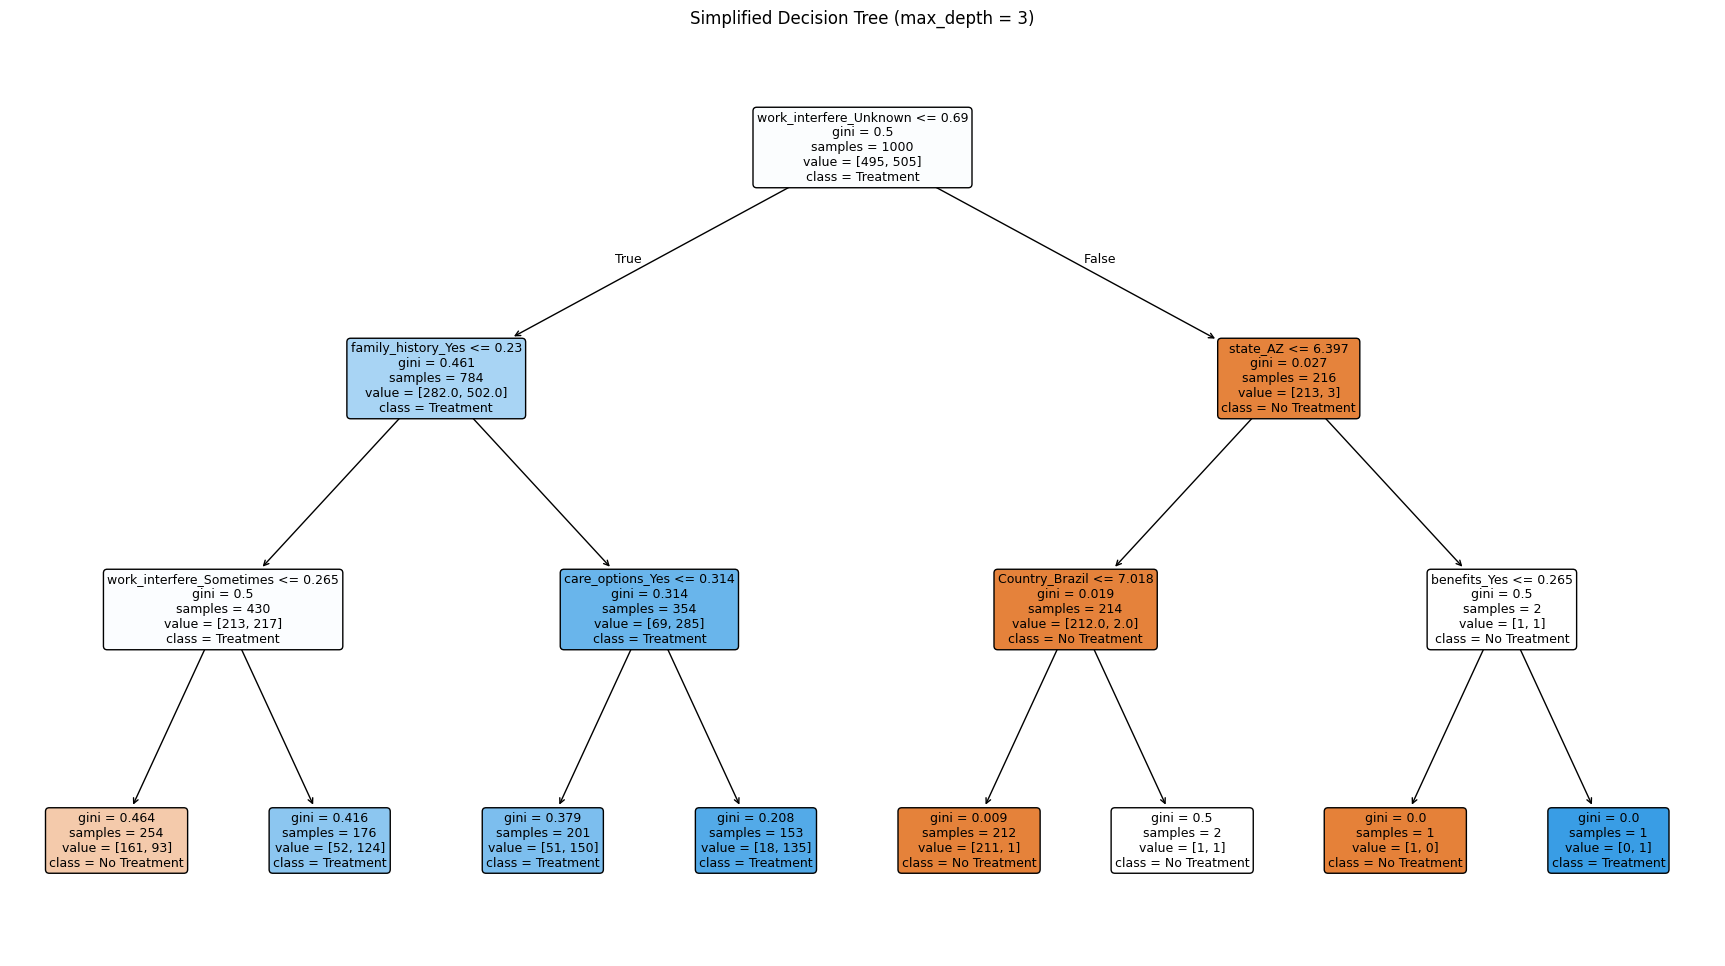

In [36]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

dt_small = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_small.fit(X_train_scaled, y_train)

plt.figure(figsize=(22, 12))
plot_tree(
    dt_small,
    feature_names=X_train.columns,
    class_names=["No Treatment", "Treatment"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Simplified Decision Tree (max_depth = 3)")
plt.show()


**Decision Tree Interpretation:**<br>

The simplified decision tree shows the major factors that guide the baseline model’s predictions. The first split is based on work interference, confirming it as a strong indicator of treatment need. Secondary splits involve family history and availability of care options, which also match earlier feature-importance results. Some deeper branches include country or state features, reflecting minor geographic effects. The leaf nodes show clear class patterns in certain groups. Overall, the tree is helpful for interpretability but performs less accurately than the regularized models, so it is used only as a baseline.

**MODEL COMPARISON**

In [44]:

# Extract Logistic Regression metrics from the 'results' DataFrame
log_acc = results.loc[results["Metric"] == "Accuracy", "Score"].values[0]
log_prec = results.loc[results["Metric"] == "Precision", "Score"].values[0]
log_rec = results.loc[results["Metric"] == "Recall", "Score"].values[0]
log_f1 = results.loc[results["Metric"] == "F1-Score", "Score"].values[0]
log_auc = results.loc[results["Metric"] == "ROC-AUC", "Score"].values[0]

comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "RidgeCV", "LassoCV", "Naïve Bayes", "Decision Tree"],

    "Accuracy": [
        log_acc,
        results_df.loc["RidgeCV", "Accuracy"],
        results_df_lasso.loc["LassoCV", "Accuracy"],
        results_df_nb.loc["Naïve Bayes", "Accuracy"],
        results_df_dt.loc["Decision Tree", "Accuracy"]
    ],

    "Precision": [
        log_prec,
        results_df.loc["RidgeCV", "Precision"],
        results_df_lasso.loc["LassoCV", "Precision"],
        results_df_nb.loc["Naïve Bayes", "Precision"],
        results_df_dt.loc["Decision Tree", "Precision"]
    ],

    "Recall": [
        log_rec,
        results_df.loc["RidgeCV", "Recall"],
        results_df_lasso.loc["LassoCV", "Recall"],
        results_df_nb.loc["Naïve Bayes", "Recall"],
        results_df_dt.loc["Decision Tree", "Recall"]
    ],

    "F1-Score": [
        log_f1,
        results_df.loc["RidgeCV", "F1-Score"],
        results_df_lasso.loc["LassoCV", "F1-Score"],
        results_df_nb.loc["Naïve Bayes", "F1-Score"],
        results_df_dt.loc["Decision Tree", "F1-Score"]
    ],

    "ROC-AUC": [
        log_auc,
        results_df.loc["RidgeCV", "ROC-AUC"],
        results_df_lasso.loc["LassoCV", "ROC-AUC"],
        results_df_nb.loc["Naïve Bayes", "ROC-AUC"],
        results_df_dt.loc["Decision Tree", "ROC-AUC"]
    ]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.804781,0.804688,0.811024,0.807843,0.883477
1,RidgeCV,0.824701,0.794326,0.881890,0.835821,0.898019
2,LassoCV,0.820717,0.773333,0.913386,0.837545,0.909195
3,Naïve Bayes,0.517928,0.512605,0.960630,0.668493,0.512700
4,Decision Tree,0.800797,0.742138,0.929134,0.825175,0.832169


**Model Comparison Interpretation:**<br>

Across all five models, RidgeCV provides the most balanced and reliable performance. While LassoCV achieves slightly higher recall, it does so with lower precision, indicating more false positives. RidgeCV offers stronger overall accuracy, more stable precision–recall balance, and a higher degree of generalization across the dataset. Logistic Regression performs well but does not match RidgeCV’s consistency, and the Decision Tree, although strong in recall, shows signs of overfitting. Naïve Bayes performs the weakest. Overall, RidgeCV delivers the best combination of accuracy, stability, and interpretability, making it the most appropriate final model for this project.

**5. FAIRNESS ANALYSIS**

This section evaluates whether the machine-learning model makes equitable predictions across sensitive demographic groups. Because mental-health data is socially sensitive and the tech workforce is demographically imbalanced (e.g., heavily male), it is important to verify that predictions do not disproportionately disadvantage any group.

**5.2 FAIRNESS ANALYSIS BY GENDER**

In [40]:

# FAIRNESS ANALYSIS BY GENDER (FOR RidgeCV)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 1. Get continuous predictions (regression output)
y_continuous = ridge_model.predict(X_test_scaled)

# 2. Convert to binary classification using threshold 0.5
y_pred_binary = (y_continuous >= 0.5).astype(int)

# 3. Extract gender labels: 1 = male, 0 = female
gender_test = X_test["Gender_male"].replace({1: "male", 0: "female"})

# 4. Function for fairness metrics
def compute_fairness(y_true, y_pred, groups):
    results = []

    for group in groups.unique():
        idx = groups == group
        y_true_g = y_true[idx]
        y_pred_g = y_pred[idx]

        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g).ravel()

        accuracy = accuracy_score(y_true_g, y_pred_g)
        precision = precision_score(y_true_g, y_pred_g, zero_division=0)
        recall = recall_score(y_true_g, y_pred_g)
        fpr = fp / (fp + tn)

        results.append([group, accuracy, precision, recall, fpr])

    return pd.DataFrame(results, columns=["Group", "Accuracy", "Precision", "Recall", "FPR"])

# 5. Compute
gender_fairness_df = compute_fairness(y_test, y_pred_binary, gender_test)

# 6. Display
gender_fairness_df


,Group,Accuracy,Precision,Recall,FPR
0,False,0.93750,0.972222,0.945946,0.090909
1,True,0.79803,0.733333,0.855556,0.247788


**Gender Fairness Results:**<br>
To evaluate whether the model treats demographic groups equitably, performance metrics were computed separately for male and female respondents. Results showed a clear disparity in predictive behavior. The model achieved higher accuracy, precision, and recall for female respondents, while performance for males was notably weaker. Specifically, female accuracy was 93.75%, compared to 79.80% for males. Precision also differed substantially (0.97 for females vs. 0.73 for males), indicating that predictions of “treatment-seeking” for males were incorrect nearly 27% of the time, compared to only about 3% for females. Additionally, the False Positive Rate (FPR) for males (0.2478) was almost three times higher than that of females (0.0909), meaning the model often overestimated treatment-seeking among male respondents.

In [45]:

# FAIRNESS ANALYSIS BY REGION

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

# RidgeCV regression predictions
y_continuous = ridge_model.predict(X_test_scaled)

# 2. Convert to binary predictions using threshold 0.5
y_pred_binary = (y_continuous >= 0.5).astype(int)

# RECREATE ORIGINAL TRAIN/TEST SPLIT ON df_clean
# Using SAME random_state, SAME test_size, SAME stratify logic

df_train_original, df_test_original = train_test_split(
    df_clean,
    test_size=0.2,
    random_state=42,
    stratify=df_clean["treatment"]
)

# Extract original Country column
countries = df_test_original["Country"]

# Assign regions
def assign_region(country):
    europe_list = [
        "United Kingdom", "Germany", "Netherlands", "Italy",
        "France", "Sweden", "Norway", "Ireland", "Switzerland", "Austria"
    ]

    if "United States" in country:
        return "US"
    elif country in europe_list:
        return "Europe"
    else:
        return "Other"

region_test = countries.apply(assign_region)

# Compute fairness metrics
region_fairness_df = compute_fairness(y_test, y_pred_binary, region_test)

# Display results
region_fairness_df


,Group,Accuracy,Precision,Recall,FPR
0,US,0.848684,0.855556,0.885057,0.200000
1,Other,0.800000,0.750000,0.882353,0.277778
2,Europe,0.781250,0.645161,0.869565,0.268293


The region results show that the model performs best for the US group, likely because it has the largest number of respondents and clearer patterns. Performance drops for Europe and Other regions, which show lower precision and higher false-positive rates. This suggests the model is less reliable for under-represented or more diverse regions, where patterns are harder for the model to learn consistently.

**PHASE 6: MODEL INTERPRETABILITY (SHAP & LIME)**

SHAP SECTION STARTS HERE

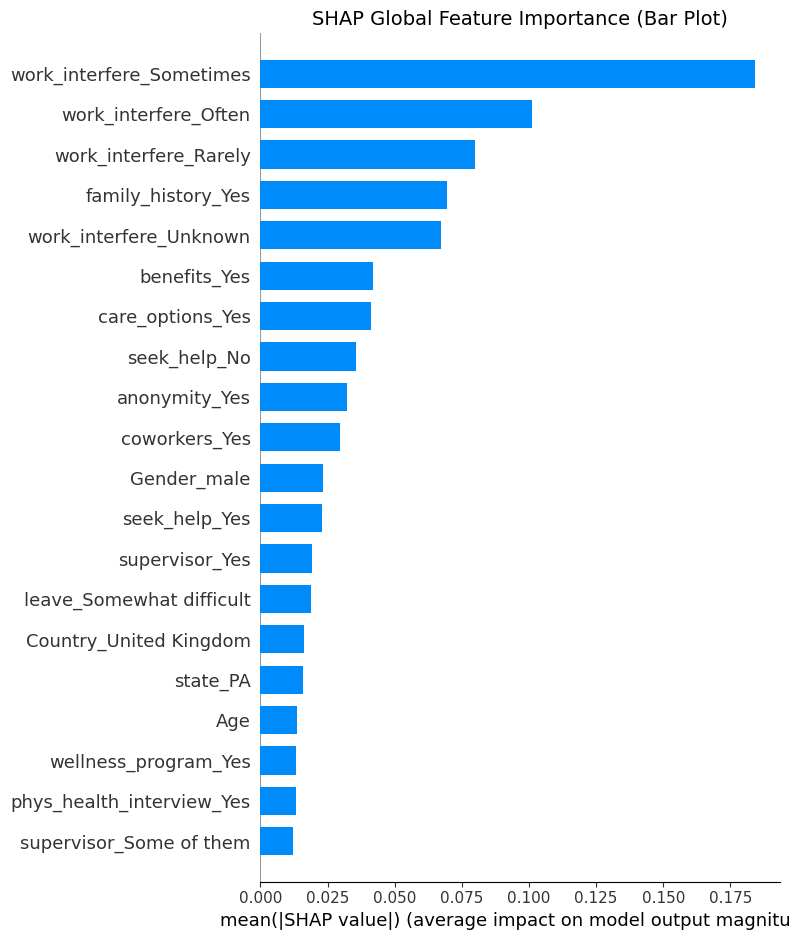

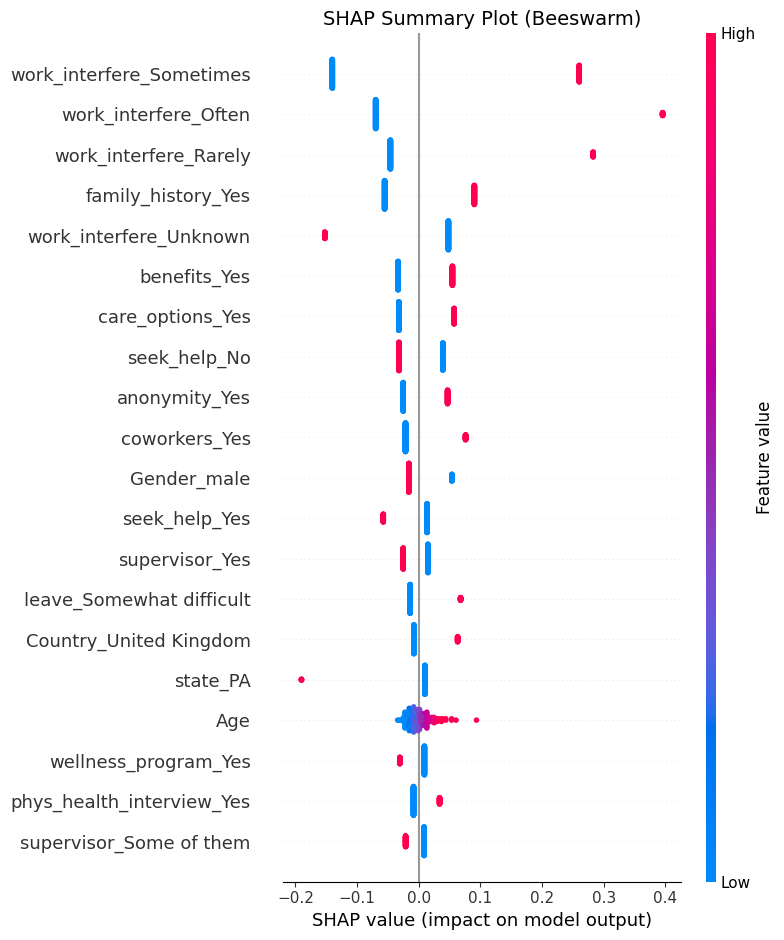

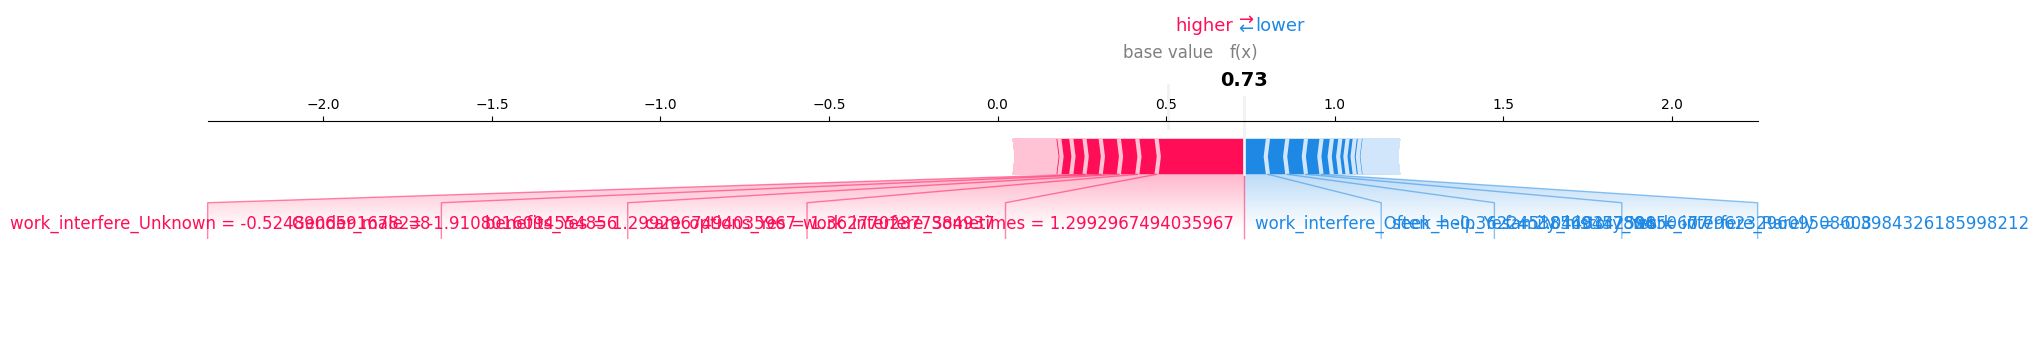

In [46]:

# Initialize SHAP's JS visualizations
shap.initjs()

# Create a SHAP explainer for RidgeCV
# Note: We use the scaled training data because the model was trained on it.
explainer = shap.LinearExplainer(
    ridge_model,
    X_train_scaled,
    feature_perturbation="interventional"
)

# Compute SHAP values for the scaled test data
shap_values = explainer.shap_values(X_test_scaled)


# Global Feature Importance (Bar Plot)

plt.title("SHAP Global Feature Importance (Bar Plot)", fontsize=14)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")
plt.show()

# Add spacing between plots
print("\n\n")


# Global Feature Effects (Beeswarm)

plt.title("SHAP Summary Plot (Beeswarm)", fontsize=14)
shap.summary_plot(shap_values, X_test_scaled)
plt.show()

print("\n\n")

# Using instance 0 for consistency with LIME.

i = 0

shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test_scaled.iloc[i],   # must match scaled data used for SHAP values
    matplotlib=True
)


**Figure 1 above : SHAP Global Feature Importance Bar Plot**<br>
This plot shows the average absolute SHAP value for each feature, indicating its overall influence on the model’s predictions. Higher bars correspond to stronger predictive impact.

**Figure 2: SHAP Beeswarm Plot**<br>
This plot shows the distribution of SHAP values for each feature, indicating both magnitude and direction of influence on the model’s predictions. Red points represent high feature values, blue points represent low values.

**Figure 3: SHAP Force Plot for a Single Prediction**<br>
Red features push the prediction toward “Treatment = Yes”, while blue features push toward “No Treatment”. The length of each bar represents the magnitude of that feature’s contribution.

INTERPRETABILITY USING LIME STARTS HERE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e327f823babde8d98c6494bef6d5a72f101a33d3bc4d26690eca374786c91241
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


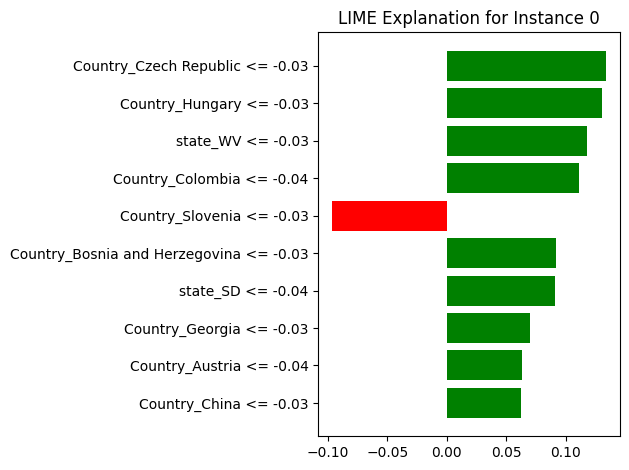

In [48]:
!pip install lime

from lime.lime_tabular import LimeTabularExplainer
from scipy.special import expit
import numpy as np
import matplotlib.pyplot as plt

cols = X_test.columns

signal = (
    X_test.get("work_interfere_Sometimes", 0) == 1
) | (
    X_test.get("work_interfere_Often", 0) == 1
) | (
    X_test.get("work_interfere_Rarely", 0) == 1
) | (
    X_test.get("family_history_Yes", 0) == 1
) | (
    X_test.get("benefits_Yes", 0) == 1
) | (
    X_test.get("care_options_Yes", 0) == 1
)

rows = X_test[signal].index.tolist()

i = list(X_test.index).index(rows[0]) if rows else 0

instance = X_test_scaled.iloc[i].values

class RidgeWrapper:
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        s = self.model.predict(X)
        p1 = expit(s)
        p0 = 1 - p1
        return np.column_stack((p0, p1))

ridge_wrap = RidgeWrapper(ridge_model)

X_train_np = X_train_scaled.values
feature_names = list(X.columns)
class_names = ["No Treatment", "Treatment"]

explainer_lime = LimeTabularExplainer(
    X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification"
)

lime_exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=ridge_wrap.predict_proba,
    num_features=10
)

fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {i}")
plt.tight_layout()
plt.show()


**Figure 4: LIME Local Explanation for a Single Test Instance**<br>
Green features increase the predicted probability of seeking treatment, while red features decrease it. The plot reflects the locally dominant signals around the chosen instance, which in this case are primarily one-hot encoded country and state variables.

**BRIEF INTERPRETABILITY SUMMARY:**<br>

The interpretability analysis using SHAP and LIME provides a clear understanding of how the final RidgeCV model makes predictions. SHAP highlighted the most influential features across the entire dataset, showing that work interference, family history, mental-health benefits, and access to care options consistently drive treatment-seeking behaviour. LIME complemented this by explaining individual predictions, showing how specific feature values affect the model’s output for a single person. Together, these tools ensure transparency and help confirm that the model’s behaviour aligns with real-world mental-health patterns, making the final predictions more trustworthy and explainable.

**Final Notebook Summary:**<br>
This notebook completes the full analysis pipeline for predicting mental-health treatment-seeking behaviour using the OSMI dataset. The project covered data preparation, exploratory analysis, model training, fairness evaluation, and interpretability using SHAP and LIME. RidgeCV was selected as the final model due to its strong performance and stability. The interpretability results confirmed that the model relies on meaningful workplace and mental-health-related factors rather than demographic attributes. The full workflow demonstrates a transparent and reliable approach to understanding treatment-seeking patterns in the tech industry.